In [1]:
import json
import os
from qmap.toolkit import aligner
from qmap.toolkit import split
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import EsmTokenizer, EsmModel
from pyutils import progress
from sklearn.linear_model import LinearRegression
from pyutils import Colors
import pickle
from scipy.stats import pearsonr
COLORS = ['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E', "#ADFF2F", "#FF8200"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.rcParams.update({'font.size': 14})

In [2]:
with open('../data/build/dataset.json', 'r') as f:
    dataset = json.load(f)
dataset = [sample for sample in dataset if len(sample['Sequence']) <= 100]
dataset[0].keys()

dict_keys(['ID', 'Sequence', 'N Terminus', 'N Terminus Name', 'C Terminus', 'C Terminus Name', 'Unusual Amino Acids', 'Unusual Amino Acids Names', 'Targets', 'Hemolitic Activity', 'Cytotoxic Activity'])

# ML prediction
To assert the best splitting threshold, we will generate embeddings using ESM2 650M and use a linear regressor to predict the log MIC values. We will try different thresholds and plot the test performances.

In [4]:
def generate_esm2_embeddings(protein_sequences: list[str],
                             model_name: str = "facebook/esm2_t33_650M_UR50D",
                             device: str = None,
                             batch_size: int = 1) -> np.ndarray:
    """
    Generate protein embeddings using ESM2 model with mean pooling.

    Args:
        protein_sequences (List[str]): List of protein sequences (amino acid sequences)
        model_name (str): Name of the ESM2 model to use. Options include:
            - "facebook/esm2_t6_8M_UR50D" (8M parameters)
            - "facebook/esm2_t12_35M_UR50D" (35M parameters)
            - "facebook/esm2_t30_150M_UR50D" (150M parameters)
            - "facebook/esm2_t33_650M_UR50D" (650M parameters) - default
            - "facebook/esm2_t36_3B_UR50D" (3B parameters)
            - "facebook/esm2_t48_15B_UR50D" (15B parameters)
        device (str): Device to run the model on ('cuda', 'cpu', or None for auto-detection)
        batch_size (int): Batch size for processing sequences

    Returns:
        np.ndarray: Array of shape (num_sequences, embedding_dim) containing embeddings
                   in the same order as input sequences
    """

    # Set device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load tokenizer and model
    tokenizer = EsmTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)
    model.to(device)
    model.eval()

    all_embeddings = []

    # Process sequences in batches
    for i in progress(range(0, len(protein_sequences), batch_size)):
        batch_sequences = protein_sequences[i:i + batch_size]

        # Tokenize sequences
        inputs = tokenizer(batch_sequences,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=1024)

        # Move to device
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Process each sequence in the batch
        for j in range(len(batch_sequences)):
            # Get attention mask for this sequence (to exclude padding tokens)
            attention_mask = inputs['attention_mask'][j]
            seq_embeddings = hidden_states[j][attention_mask.bool()]  # Remove padding

            # Remove special tokens (CLS and EOS tokens)
            seq_embeddings_no_special = seq_embeddings[1:-1]  # Remove first (CLS) and last (EOS) tokens

            # Mean pooling
            seq_embedding = seq_embeddings_no_special.mean(dim=0)
            all_embeddings.append(seq_embedding.cpu().numpy())

    return np.array(all_embeddings)

In [5]:
if not os.path.exists(".cache/esm2_embeddings.npy"):
    embs = generate_esm2_embeddings([sample["Sequence"] for sample in dataset], batch_size=128, device="mps")
    np.save(".cache/esm2_embeddings.npy", embs)
else:
    embs = np.load(".cache/esm2_embeddings.npy")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 100%|████████████████████████████████████████|  149/149 [13:13<00:00, 5.02s/it] 


In [26]:
# Note: takes 2 to 3h to run on my M4 MB
thresholds = [0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.8, 0.9, 0.99]
if os.path.exists(".cache/pcc_trains.npy") and os.path.exists(".cache/pcc_tests.npy") and os.path.exists(".cache/max_idens_median.npy") and os.path.exists(".cache/max_idens_99th.npy"):
    pcc_trains = np.load(".cache/pcc_trains.npy")
    pcc_tests = np.load(".cache/pcc_tests.npy")
    max_idens_median = np.load(".cache/max_idens_median.npy")
    max_idens_99th = np.load(".cache/max_idens_99th.npy")
else:
    # Try different thresholds
    pcc_trains = np.empty((len(thresholds), 5))
    pcc_tests = np.empty((len(thresholds), 5))
    max_idens_median = np.empty((len(thresholds), 5))
    max_idens_99th = np.empty((len(thresholds), 5))
    for i, threshold in enumerate(thresholds):
        for j in range(5 if threshold != 0.3 else 1):
            train_seq, test_seq, train_embs, test_embs, train_samples, test_samples = split.train_test_split(
                [sample["Sequence"] for sample in dataset],
                embs,
                dataset,
                threshold=threshold,
                post_filtering=True,
                n_iterations=2
            )
            print(f"Train size: {len(train_seq)}, Test size: {len(test_seq)}")

            train_y = np.array([sample['Targets']['Escherichia coli'][0] if 'Escherichia coli' in sample['Targets'] else np.nan for sample in train_samples])
            train_y[np.isinf(train_y)] = np.nan
            mask = ~np.isnan(train_y)
            train_y = np.log10(train_y[mask])
            train_embs = np.array(train_embs)[mask]
            indices = np.arange(len(train_y))
            np.random.shuffle(indices)
            indices = indices[:3000]

            train_seq = [seq for i, seq in enumerate(train_seq) if i in indices]
            train_y = train_y[indices]
            train_embs = train_embs[indices]

            test_y = np.array([sample['Targets']['Escherichia coli'][0] if 'Escherichia coli' in sample['Targets'] else np.nan for sample in test_samples])
            test_y[np.isinf(test_y)] = np.nan
            mask = ~np.isnan(test_y)
            test_y = np.log10(test_y[mask])
            test_embs = np.array(test_embs)[mask]

            # Compute the maximum identity distribution
            train_latent = aligner.Encoder(force_cpu=True).encode(train_seq).embeddings
            test_latent = aligner.Encoder(force_cpu=True).encode(test_seq).embeddings
            activation = aligner.Encoder(force_cpu=True).activation
            activation.half()
            with torch.inference_mode():
                iden = activation(train_latent @ test_latent.T)  # Shape (N_train, N_test)
            print(iden.shape)
            max_iden = iden.max(dim=0).values.cpu().numpy()  # Shape (N_test,)
            median_iden = np.median(max_iden)
            max_idens_median[i, j] = median_iden
            max_idens_99th[i, j] = np.quantile(max_iden, 0.99)
            # Make a linear regression model
            reg = LinearRegression()
            reg.fit(train_embs, train_y)

            pcc_train = pearsonr(reg.predict(train_embs), train_y).statistic
            pcc_test = pearsonr(reg.predict(test_embs), test_y).statistic
            pcc_trains[i, j] = pcc_train
            pcc_tests[i, j] = pcc_test
            print(f'{Colors.orange} - [it {j}]', threshold, pcc_train, pcc_test, median_iden, f'{Colors.reset}')
    np.save(".cache/pcc_trains.npy", pcc_trains)
    np.save(".cache/pcc_tests.npy", pcc_tests)
    np.save(".cache/max_idens_median.npy", max_idens_median)
    np.save(".cache/max_idens_99th.npy", max_idens_99th)

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.52 it/s eta 00:00
Found 345 clusters in the dataset.
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  10/10 it 0.36 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  29/29 it 0.57 it/s eta 00:00
Train size: 6818, Test size: 4636
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  6/6 it 0.62 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  10/10 it 0.35 it/s eta 00:00
torch.Size([3000, 4636])
 - [it 0] 0.45 0.8758146505834143 0.08567492857755236 0.3955 
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.54 it/s eta 00:00
Found 345 clusters in the dataset.
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  9/9 it 0.62 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  29/29 it 0.54 it/s eta 00:00
Train size: 5338, Test size: 4548
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  6/6 it 0.52 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━

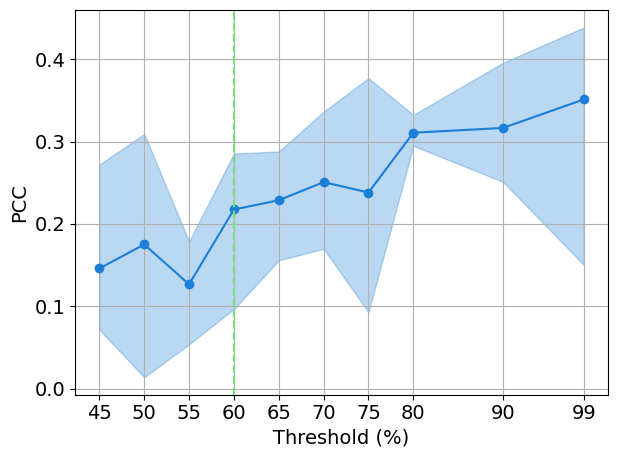

In [12]:
# plt.plot(thresholds, np.median(pcc_trains, axis=1), label='Train PCC', marker='o')
# plt.figure(figsize=(8, 4))
plt.plot(thresholds, np.mean(pcc_tests, axis=1), label='Test PCC', marker='o')
# plt.fill_between(thresholds, np.max(pcc_trains, axis=1), np.min(pcc_trains, axis=1), color="tab:blue", alpha=0.3)
plt.fill_between(thresholds, np.max(pcc_tests, axis=1), np.min(pcc_tests, axis=1), color=COLORS[0], alpha=0.3)

# Add a vertical line at the threshold of 0.55
plt.axvline(x=0.60, color=COLORS[1], linestyle='--', label='Threshold 0.60')
plt.xlabel('Threshold (%)')
plt.ylabel('PCC')
plt.xticks(thresholds, [f'{t:.2f}'[2:] for t in thresholds])
plt.grid()
# plt.title('PCC vs splitting threshold')
plt.tight_layout()
plt.savefig(".cache/figs/pcc_vs_threshold.svg")

In [22]:
for threshold, median_iden in zip(thresholds, max_idens_median):
    print(f'Threshold: {threshold:.2f}, Median max identity: {median_iden.mean():.2f}+-{median_iden.std():.2f}')

Threshold: 0.45, Median max identity: 0.38+-0.01
Threshold: 0.50, Median max identity: 0.43+-0.01
Threshold: 0.55, Median max identity: 0.46+-0.01
Threshold: 0.60, Median max identity: 0.50+-0.01
Threshold: 0.65, Median max identity: 0.54+-0.01
Threshold: 0.70, Median max identity: 0.56+-0.01
Threshold: 0.75, Median max identity: 0.59+-0.02
Threshold: 0.80, Median max identity: 0.62+-0.01
Threshold: 0.90, Median max identity: 0.71+-0.02
Threshold: 0.99, Median max identity: 0.78+-0.02


# Real world distance
Next, we aim to evaluate the distances of real world sequences to the DBAASP database to get a sense of the real world distance between any sequence and the training set.

In [14]:
# Read the peptide atlas data and we will compare its distance to the DBAASP database to get a sense of the real world distance between sequences
def read_fasta(file_path):
    """
    Reads a FASTA file and returns a list of tuples containing sequence IDs and sequences.
    :param file_path: The path to the FASTA file.
    :return:
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    sequences = []
    for line in lines:
        if line.startswith('>'):
            id_ = line[1:].strip()
        else:
            sequence = line.strip()
            sequences.append((id_, sequence))
    return sequences
peptide_atlas = read_fasta("../data/.cache/peptide_atlas.fasta")

In [15]:
# ~1h to run
if not os.path.exists('.cache/tmp_atlas.pkl'):
    encoder = aligner.Encoder()
    atlas_db = encoder.encode([seq for _, seq in peptide_atlas])
    with open('.cache/tmp_atlas.pkl', 'wb') as f:
        pickle.dump(atlas_db, f)
else:
    with open('.cache/tmp_atlas.pkl', 'rb') as f:
        atlas_db = pickle.load(f)

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━  6975/6975 it 1.23 it/s eta 00:00


In [16]:
# Takes around 2h to run on M4 MBP
# Compute the max identity between atlas and dbaasp sequences
max_iden_natural = np.empty(len(atlas_db))
if not os.path.exists(".cache/max_iden.npy"):
    encoder = aligner.Encoder(force_cpu=True)
    dbaasp_db = encoder.encode([sample['Sequence'] for sample in dataset])
    activation = encoder.activation
    activation.half()
    with torch.inference_mode():
        for i, (seq, emb) in enumerate(progress(atlas_db)):
            iden = torch.max(activation(dbaasp_db.embeddings @ emb.unsqueeze(1)))
            max_iden_natural[i] = iden.item()
        np.save(".cache/max_iden.npy", max_iden_natural)
else:
    max_iden_natural = np.load(".cache/max_iden.npy")


Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.50 it/s eta 00:00
 100%|███████████████████████████|  3570953/3570953 [01:31:20<00:00, 367.07it/s] 


Quantiles:
- 0.01 quantile: 0.343505859375
- 0.05 quantile: 0.363037109375
- 0.10 quantile: 0.375
- 0.25 quantile: 0.3974609375
- 0.50 quantile: 0.42822265625
- 0.75 quantile: 0.4658203125
- 0.90 quantile: 0.505859375
- 0.95 quantile: 0.533203125
- 0.99 quantile: 0.59326171875


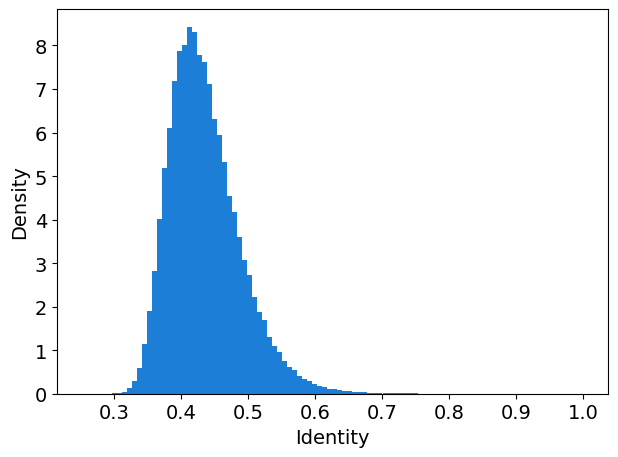

In [20]:
# This distribution is equivalent to a random split with a threshold of 0.55
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(max_iden_natural, q)}")
plt.hist(max_iden_natural, bins=100, density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(".cache/figs/natural_max_iden.svg")

In [18]:
np.quantile(max_iden_natural, [0.5, 0.75, 0.9, 0.95, 0.99])

array([0.42822266, 0.46582031, 0.50585938, 0.53320312, 0.59326172])